In [1]:
from proj_utils import *
import os, struct
import matplotlib as plt
from array import array as pyarray
import pandas as pd
from openpyxl import load_workbook
from pylab import *
import numpy as np
from keras.layers import Input, Dense
from keras.models import Model

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
path = os.path.join(os.path.curdir, 'data')
x_train, y_train = load_NMNIST('training', digits=[0,1,2], path=path)
x_test, y_test = load_NMNIST('testing', digits=[0,1,2], path=path)

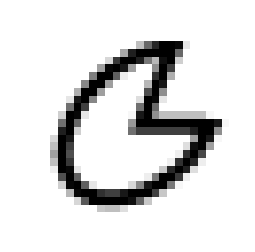

In [3]:
vectortoimg(x_train[1])

Checking multiple training vectors by plotting images.
Be patient:


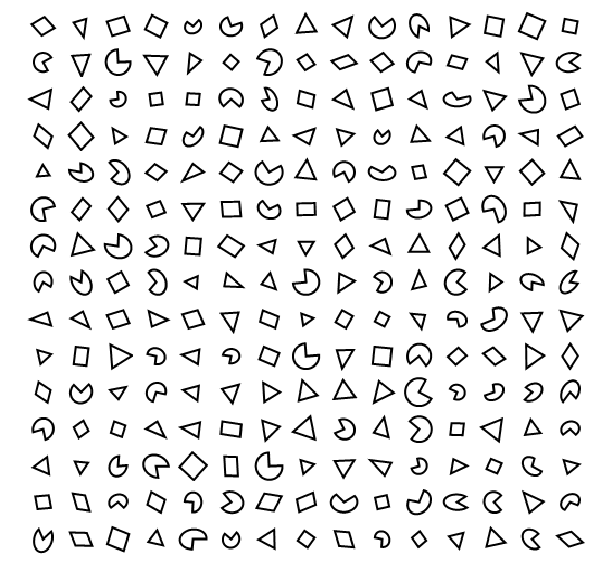

In [4]:
print("Checking multiple training vectors by plotting images.\nBe patient:")
plt.close('all')
fig = plt.figure(figsize=(10,10))
nrows=15
ncols=15
for row in range(nrows):
    for col in range(ncols):
        plt.subplot(nrows, ncols, row*ncols+col + 1)
        v = x_train[np.random.randint(len(x_train))]
        plt.imshow(v.reshape(28, 28),interpolation='None', cmap='gray')
        plt.axis('off')
plt.show()

In [5]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

((60000, 28, 28), (60000, 1), (10000, 28, 28), (10000, 1))


## KMeans

In [6]:
from  sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [7]:
x_train_2d = np.reshape(x_train, (len(x_train), 28*28*1))
x_test_2d = np.reshape(x_test, (len(x_test), 28*28*1))

In [8]:
def kmeans(train, test):
    estimator = KMeans(n_clusters=3, n_jobs=20)
    return estimator.fit(train).predict(test)
def kmeans_pca(train, test):
    pca = PCA(n_components=3).fit(train)
    estimator = KMeans(init=pca.components_, n_clusters=3, n_init=20)
    return estimator.fit(train).predict(test)

In [9]:
%%timeit
_ = kmeans(x_train_2d, x_test_2d)

1 loop, best of 3: 12.6 s per loop


In [10]:
print(labeled_cluster_accuracy(y_test, kmeans(x_train_2d, x_test_2d)))

0.4994


# KMeans with PCA

In [11]:
%%timeit
_ = kmeans_pca(x_train_2d, x_test_2d)

/usr/local/lib/python2.7/dist-packages/sklearn/cluster/k_means_.py:893: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=20
  return_n_iter=True)


1 loop, best of 3: 6.5 s per loop


In [12]:
print(labeled_cluster_accuracy(y_test, kmeans_pca(x_train_2d, x_test_2d)))

0.4995


# AUTOENCODERS

In [103]:
#hyper-parameters
EPOCH=500
BATCH_SIZE=256

## single fully-connected neural layer as encoder and as decoder

In [85]:
# this is the size of our encoded representations
encoding_dim = 32  # 3 floats -> 3 floats represents 3 classes

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

## Let's also create a separate encoder model

In [86]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

## decoder model

In [87]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

## Use Crossentropy loss, and Adadelta Optimizer

In [88]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [89]:
x_train_autoencoder = x_train.astype('float32') / 255.
x_test_autoencoder = x_test.astype('float32') / 255.
x_train_autoencoder = x_train_autoencoder.reshape((len(x_train), np.prod(x_train_autoencoder.shape[1:])))
x_test_autoencoder = x_test_autoencoder.reshape((len(x_test), np.prod(x_test_autoencoder.shape[1:])))
print(x_train_autoencoder.shape)
print(x_test_autoencoder.shape)

(60000, 784)
(10000, 784)


In [90]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

## Train

In [104]:
simple_model_cp_name = 'weights.best.simple_model.hdf5'
autoencoder.fit(x_train_autoencoder, x_train_autoencoder,
                epochs=EPOCH,
                batch_size=BATCH_SIZE,
                shuffle=True,
                callbacks=[ModelCheckpoint(simple_model_cp_name, monitor='val_loss', verbose=1, save_best_only=True),
                           ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=2, factor=0.5)],
                validation_data=(x_test_autoencoder, x_test_autoencoder))

Train on 60000 samples, validate on 10000 samples
Epoch 1/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.1291 - val_loss: 0.1167
Epoch 2/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.1290 - val_loss: 0.1161
Epoch 3/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.1289 - val_loss: 0.1160
Epoch 4/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.1288 - val_loss: 0.1163
Epoch 5/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.1287 - val_loss: 0.1161
Epoch 6/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.1285 - val_loss: 0.1164
Epoch 7/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.1285 - val_loss: 0.1160
Epoch 8/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.1284 - val_loss: 0.1154
Epoch 9/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.1283 - val_loss: 0.1158
Epoch

KeyboardInterrupt: 

In [107]:
def eval_autoencoder(autoencoder, x_test, y_test):
    encoded_imgs = autoencoder.predict(x_test)
    decoded_imgs = autoencoder.predict(encoded_imgs)
    
    n = 10  # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
    encoded_imgs = np.reshape(encoded_imgs, (encoded_imgs.shape[0], -1))
    print("Accuracy = {}".format(labeled_cluster_accuracy(y_test, kmeans_pca(encoded_imgs, encoded_imgs))))

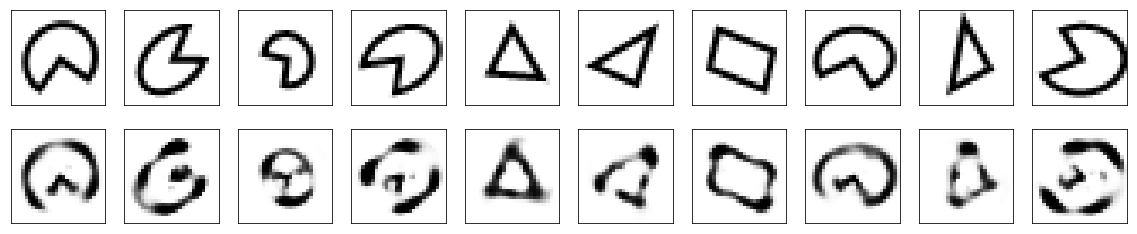

Accuracy = 0.684516666667


In [108]:
autoencoder.load_weights(simple_model_cp_name)
eval_autoencoder(autoencoder, x_train_autoencoder, y_train)

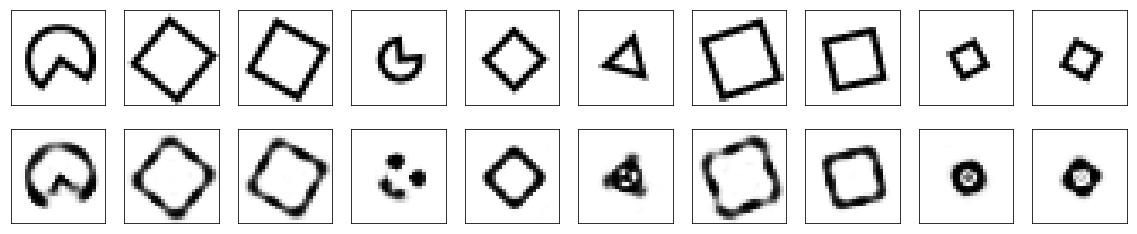

Accuracy = 0.4471


In [109]:
eval_autoencoder(autoencoder, x_test_autoencoder, y_test)

In [74]:
input_img = Input(shape=(784,))
encoded = Dense(512, activation='relu')(input_img)
encoded = Dense(256, activation='relu')(encoded)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(256, activation='relu')(decoded)
decoded = Dense(512, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

dense_model_cp_name = 'weights.best.dense_model.hdf5'
autoencoder.fit(x_train_autoencoder, x_train_autoencoder,
                epochs=EPOCH,
                batch_size=BATCH_SIZE,
                shuffle=True,
                callbacks=[ModelCheckpoint(dense_model_cp_name, monitor='val_loss', verbose=1, save_best_only=True),
                           ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=2, factor=0.5)],
                validation_data=(x_test_autoencoder, x_test_autoencoder))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.3408 - val_loss: 0.2874
Epoch 2/50
60000/60000 [==============================] - 1s 16us/step - loss: 0.2942 - val_loss: 0.2762
Epoch 3/50
60000/60000 [==============================] - 1s 16us/step - loss: 0.2790 - val_loss: 0.2613
Epoch 4/50
60000/60000 [==============================] - 1s 18us/step - loss: 0.2700 - val_loss: 0.2509
Epoch 5/50
60000/60000 [==============================] - 1s 21us/step - loss: 0.2656 - val_loss: 0.2472
Epoch 6/50
60000/60000 [==============================] - 1s 21us/step - loss: 0.2631 - val_loss: 0.2409
Epoch 7/50
60000/60000 [==============================] - 1s 21us/step - loss: 0.2609 - val_loss: 0.2372
Epoch 8/50
60000/60000 [==============================] - 1s 19us/step - loss: 0.2570 - val_loss: 0.2258
Epoch 9/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.2511 - val_loss: 0.2161
Epoch

Epoch 33/50
60000/60000 [==============================] - 1s 18us/step - loss: 0.1351 - val_loss: 0.1700
Epoch 34/50
60000/60000 [==============================] - 1s 17us/step - loss: 0.1323 - val_loss: 0.1672
Epoch 35/50
60000/60000 [==============================] - 1s 17us/step - loss: 0.1297 - val_loss: 0.1682
Epoch 36/50
60000/60000 [==============================] - 1s 17us/step - loss: 0.1271 - val_loss: 0.1647
Epoch 37/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.1244 - val_loss: 0.1633
Epoch 38/50
60000/60000 [==============================] - 1s 21us/step - loss: 0.1222 - val_loss: 0.1733
Epoch 39/50
60000/60000 [==============================] - 1s 16us/step - loss: 0.1199 - val_loss: 0.1735
Epoch 40/50
60000/60000 [==============================] - 1s 15us/step - loss: 0.1183 - val_loss: 0.1694
Epoch 41/50
60000/60000 [==============================] - 1s 15us/step - loss: 0.1161 - val_loss: 0.1666
Epoch 42/50
60000/60000 [=====================

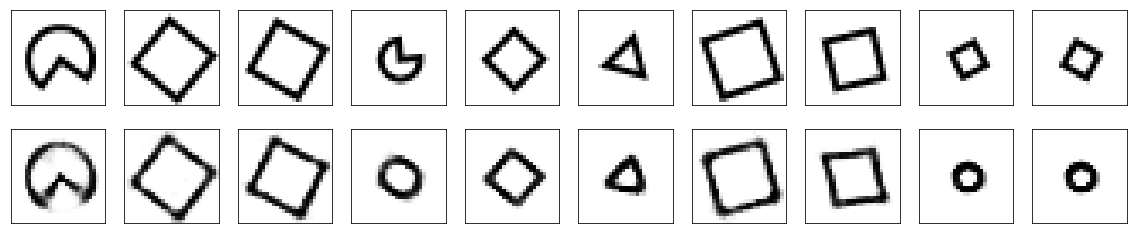

Accuracy = 0.4659


In [76]:
autoencoder.load_weights(dense_model_cp_name)
eval_autoencoder(autoencoder, x_test_autoencoder, y_test)

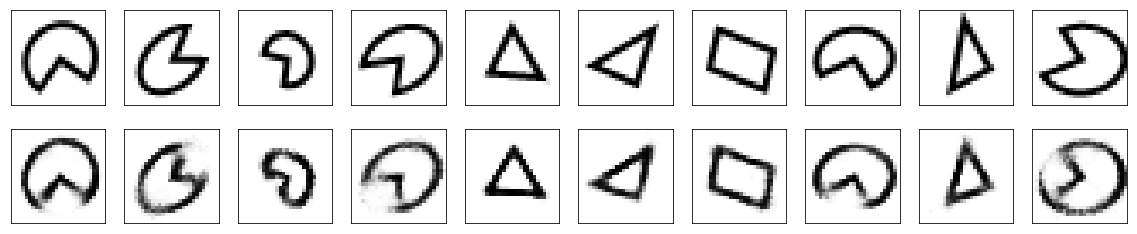

Accuracy = 0.687766666667


In [77]:
eval_autoencoder(autoencoder, x_train_autoencoder, y_train)

In [78]:
x_train_cnn = np.reshape(x_train_autoencoder, (len(x_train), 28, 28, 1)) 
x_test_cnn = np.reshape(x_test_autoencoder, (len(x_test), 28, 28, 1))

In [79]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [80]:
from keras.callbacks import TensorBoard
cnn_model_cp_name = 'weights.best.cnn_model.hdf5'
autoencoder.fit(x_train_cnn, x_train_cnn,
                epochs=EPOCH,
                batch_size=BATCH_SIZE,
                shuffle=True,
                validation_data=(x_test_cnn, x_test_cnn),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder'),
                           ModelCheckpoint(cnn_model_cp_name, monitor='val_loss', verbose=1, save_best_only=True),
                           ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=2, factor=0.5)])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 42us/step - loss: 0.3064 - val_loss: 0.1821
Epoch 2/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.2030 - val_loss: 0.1594
Epoch 3/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.1708 - val_loss: 0.1349
Epoch 4/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.1542 - val_loss: 0.1257
Epoch 5/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.1442 - val_loss: 0.1207
Epoch 6/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.1368 - val_loss: 0.1170
Epoch 7/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.1315 - val_loss: 0.1127
Epoch 8/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.1272 - val_loss: 0.1086
Epoch 9/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.1242 - val_loss: 0.1093
Epoch

Epoch 33/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.1038 - val_loss: 0.0936
Epoch 34/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.1035 - val_loss: 0.0928
Epoch 35/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.1032 - val_loss: 0.0919
Epoch 36/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.1026 - val_loss: 0.0921
Epoch 37/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.1025 - val_loss: 0.0944
Epoch 38/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.1023 - val_loss: 0.0918
Epoch 39/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.1018 - val_loss: 0.0907
Epoch 40/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.1017 - val_loss: 0.0908
Epoch 41/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.1014 - val_loss: 0.0919
Epoch 42/50
60000/60000 [=====================

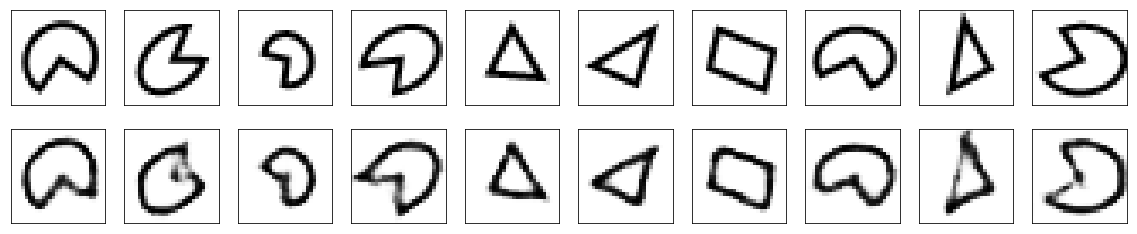

Accuracy = 0.68485


In [81]:
autoencoder.load_weights(cnn_model_cp_name)
eval_autoencoder(autoencoder, x_train_cnn, y_train)

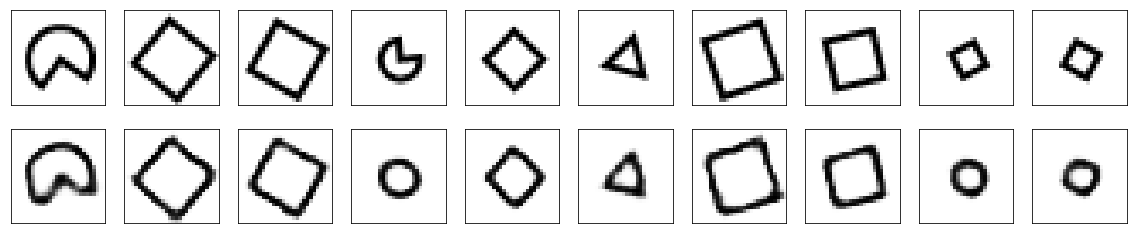

Accuracy = 0.4553


In [82]:
eval_autoencoder(autoencoder, x_test_cnn, y_test)

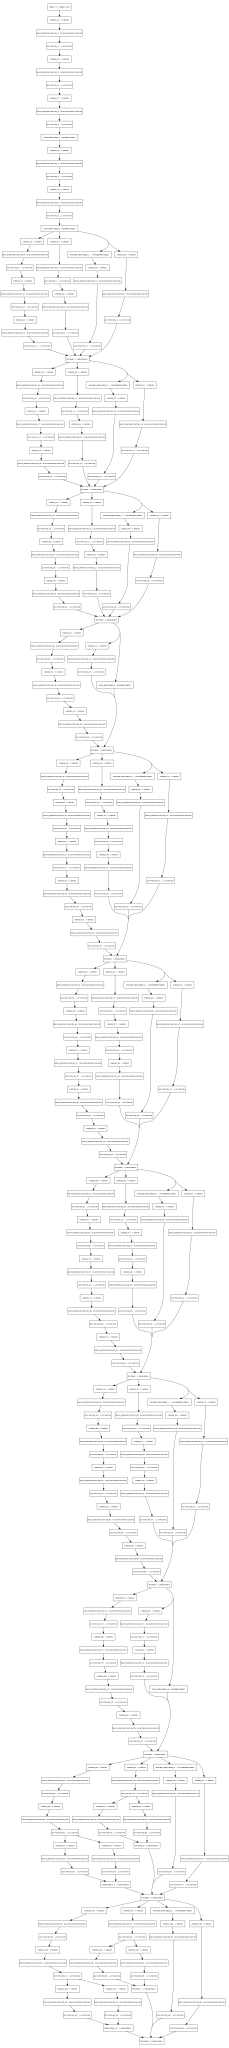

In [110]:
from IPython.display import SVG
from keras.applications.inception_v3 import InceptionV3
from keras.utils.vis_utils import model_to_dot
inception_model = InceptionV3(weights='imagenet', include_top=False)
SVG(model_to_dot(inception_model).create(prog='dot', format='svg'))

In [111]:
# check the layers by name
for i,layer in enumerate(inception_model.layers):
    print(i,layer.name)

(0, 'input_14')
(1, 'conv2d_15')
(2, 'batch_normalization_1')
(3, 'activation_1')
(4, 'conv2d_16')
(5, 'batch_normalization_2')
(6, 'activation_2')
(7, 'conv2d_17')
(8, 'batch_normalization_3')
(9, 'activation_3')
(10, 'max_pooling2d_7')
(11, 'conv2d_18')
(12, 'batch_normalization_4')
(13, 'activation_4')
(14, 'conv2d_19')
(15, 'batch_normalization_5')
(16, 'activation_5')
(17, 'max_pooling2d_8')
(18, 'conv2d_23')
(19, 'batch_normalization_9')
(20, 'activation_9')
(21, 'conv2d_21')
(22, 'conv2d_24')
(23, 'batch_normalization_7')
(24, 'batch_normalization_10')
(25, 'activation_7')
(26, 'activation_10')
(27, 'average_pooling2d_1')
(28, 'conv2d_20')
(29, 'conv2d_22')
(30, 'conv2d_25')
(31, 'conv2d_26')
(32, 'batch_normalization_6')
(33, 'batch_normalization_8')
(34, 'batch_normalization_11')
(35, 'batch_normalization_12')
(36, 'activation_6')
(37, 'activation_8')
(38, 'activation_11')
(39, 'activation_12')
(40, 'mixed0')
(41, 'conv2d_30')
(42, 'batch_normalization_16')
(43, 'activation_16

In [112]:
inception_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, None, None, 3 864         input_14[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_15[0][0]                  
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_16 